In [ ]:
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 38.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.19.2 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.


In [ ]:
import cv2
import os
import torch
import random
import pickle
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications import ResNet50
from keras.applications import VGG16
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.models import load_model, save_model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape, Lambda
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent
%matplotlib inline

In [ ]:
# Создадим две целевых атаки и загружаем тестовый набор данных из Test.csv и извлекаем изображения с меткой 14
# Преобразуем изображения в массив чисел и нормализуем
test = pd.read_csv("Test.csv")
test_imgs = test['Path'].values
data = []
y_test = []
labels = test['ClassId'].values.tolist()
i = -1

for img in test_imgs:
    i += 1
    if labels[i] != 14:
      continue
    img = image.load_img(img, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = img_array /255
    data.append(img_array)
    y_test.append(labels[i])
data = np.array(data)
y_test = np.array(y_test)
y_test = to_categorical(y_test, 43)

In [ ]:
# Реализуем целевую атаку FGSM
model=load_model('ResNet50.h5')
tf.compat.v1.disable_eager_execution()
t_class = 1
t_class = to_categorical(t_class, 43)
t_classes = np.tile(t_class, (270, 1))
x_test = data
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.2, targeted=True, batch_size=64)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]

for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_fgsm.generate(x_test, t_classes)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Adv Loss: 0.1903334829542372
Adv Accuracy: 0.9333333373069763
True Loss: 0.00491397607703995
True Accuracy: 1.0
Eps: 0.00784313725490196
Adv Loss: 0.7337295505735609
Adv Accuracy: 0.8296296000480652
True Loss: 0.00491397607703995
True Accuracy: 1.0
Eps: 0.011764705882352941
Adv Loss: 1.4126831981870862
Adv Accuracy: 0.699999988079071
True Loss: 0.00491397607703995
True Accuracy: 1.0
Eps: 0.01568627450980392
Adv Loss: 2.027206125965825
Adv Accuracy: 0.6222222447395325
True Loss: 0.00491397607703995
True Accuracy: 1.0
Eps: 0.0196078431372549
Adv Loss: 2.5781511377405235
Adv Accuracy: 0.5259259343147278
True Loss: 0.00491397607703995
True Accuracy: 1.0
Eps: 0.03137254901960784
Adv Loss: 4.070250196810122
Adv Accuracy: 0.27037036418914795
True Loss: 0.00491397607703995
True Accuracy: 1.0
Eps: 0.0392156862745098
Adv Loss: 4.889040717372188
Adv Accuracy: 0.14074073731899261
True Loss: 0.00491397607703995
True Accuracy: 1.0
Eps: 0.0784313725490196
Adv Loss: 6.283584997389052
Adv Accuracy: 0.0

In [ ]:
# Лучше всего себя показывает 10/255
eps = 10/255
attack_fgsm.set_params(**{'eps': eps})
x_test_adv = attack_fgsm.generate(x_test, t_classes)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


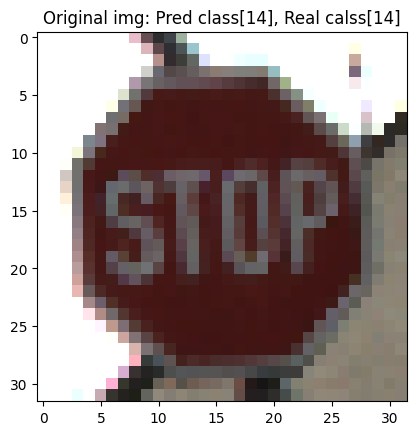

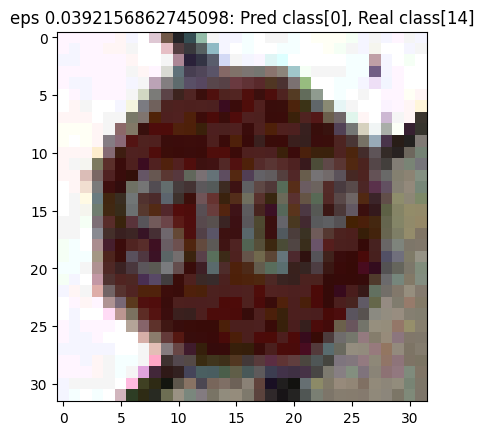

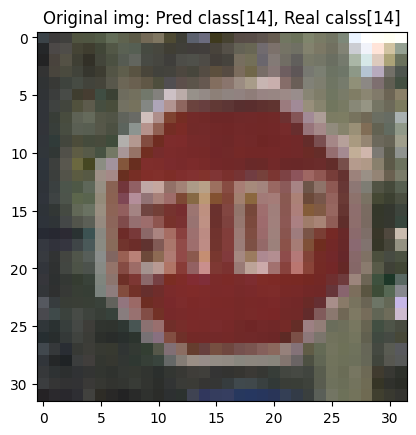

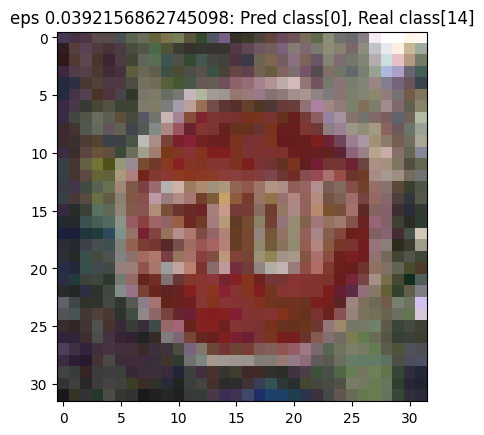

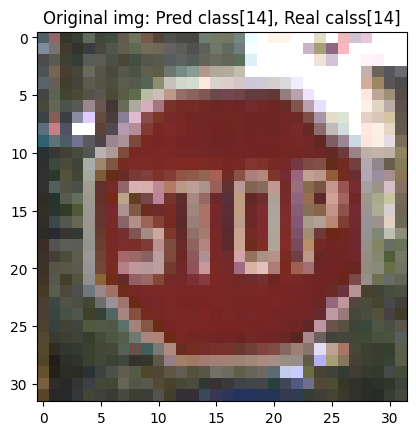

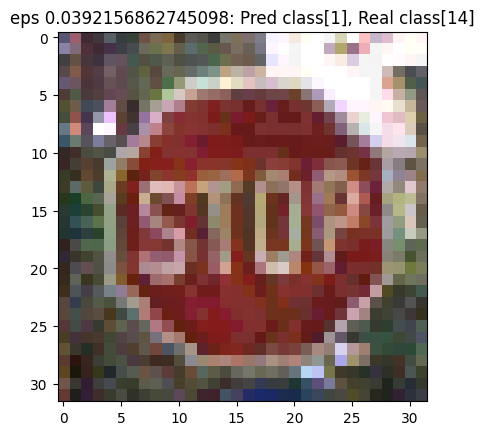

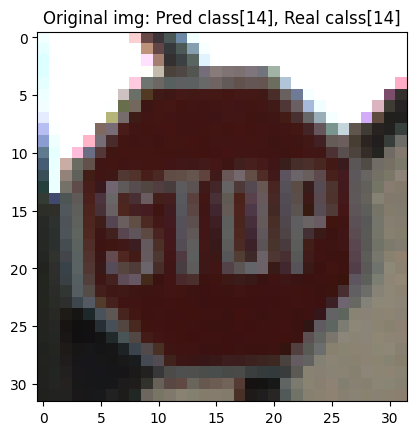

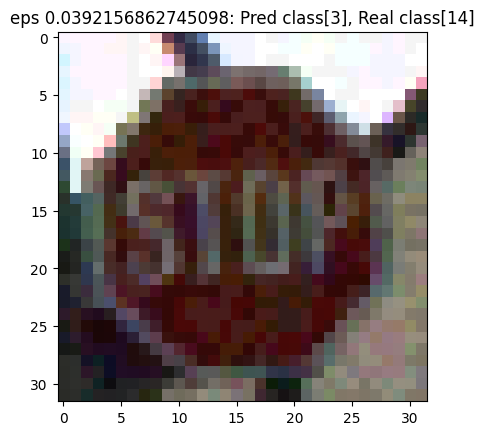

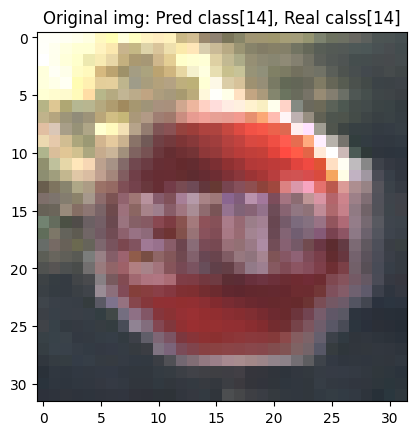

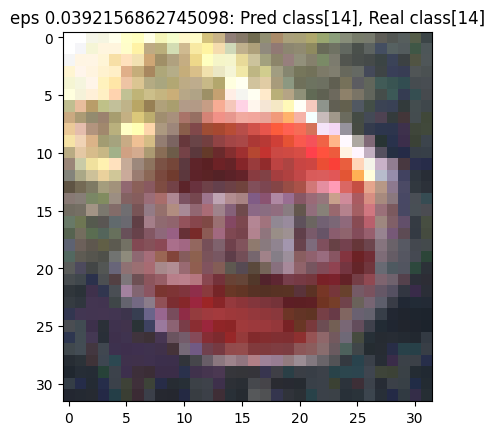

In [ ]:
# Отобразим 5 разных изображений для визуализации действия атаки
range = [0, 10, 20, 30, 40]
i = 0
for index in range:
  plt.figure(i)
  pred = np.argmax(model.predict(x_test[index:index+1]))
  plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[index])}]")
  plt.imshow(x_test[index])
  plt.show()
  i += 1
  pred = np.argmax(model.predict(x_test_adv[index:index+1]))
  plt.figure(i)
  plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[index])}]")
  plt.imshow(x_test_adv[index])
  plt.show()

In [ ]:
# Реализуем целевую атаку PGD
# сгенерируем адверсариальные примеры и оценим точность модели на адвирсариальных
# примерах и на исходных тестовых данных
model=load_model('ResNet50.h5')
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=4, verbose=False, targeted=True)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_pgd.generate(x_test, t_classes)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
Adv Loss: 0.036004904823170765
Adv Accuracy: 0.9925925731658936
True Loss: 0.00491397607703995
True Accuracy: 1.0
Eps: 0.00784313725490196
Adv Loss: 0.17419385303294768
Adv Accuracy: 0.9518518447875977
True Loss: 0.00491397607703995
True Accuracy: 1.0
Eps: 0.011764705882352941
Adv Loss: 0.4537421532251217
Adv Accuracy: 0.8925926089286804
True Loss: 0.00491397607703995
True Accuracy: 1.0
Eps: 0.01568627450980392
Adv Loss: 0.6652887706403379
Adv Accuracy: 0.8703703880310059
True Loss: 0.00491397607703995
True Accuracy: 1.0
Eps: 0.0196078431372549
Adv Loss: 1.0136789577978629
Adv Accuracy: 0.7740740776062012
True Loss: 0.00491397607703995
True Accuracy: 1.0
Eps: 0.03137254901960784
Adv Loss: 2.255227522496824
Adv Accuracy: 0.614814817905426
True Loss: 0.00491397607703995
True Accuracy: 1.0
Eps: 0.0392156862745098
Adv Loss: 3.0106800529691906
Adv Accuracy: 0.5518518686294556
True Loss: 0.00491397607703995
True Accuracy: 1.0
Eps: 0.0784313725490196
Adv Loss: 7.28974

In [ ]:
# Играемся с параметрами eps
eps = 10/255
attack_pgd.set_params(**{'eps': eps})
x_test_adv = attack_pgd.generate(x_test, t_classes)

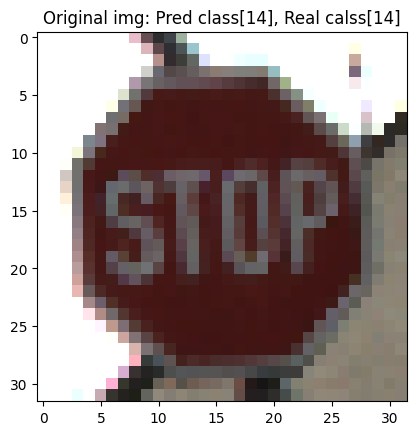

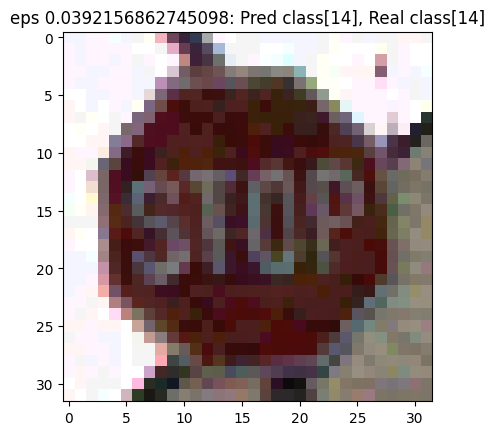

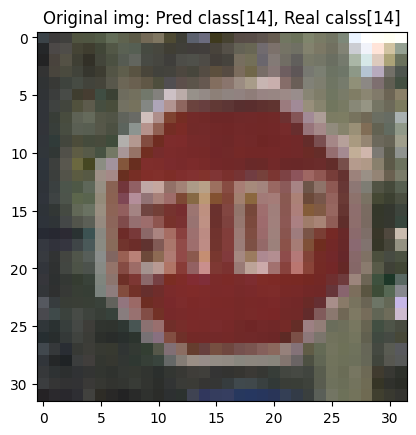

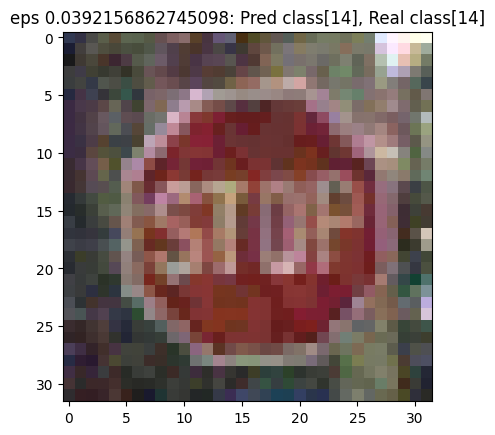

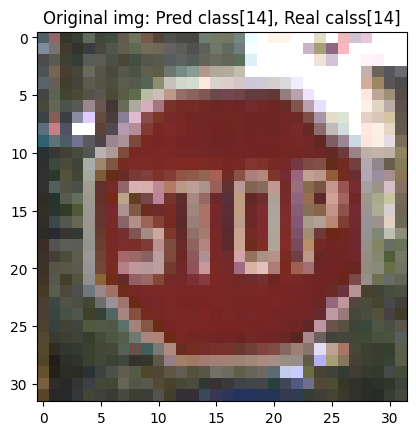

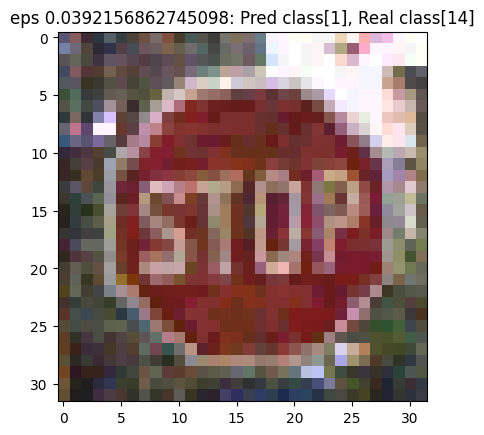

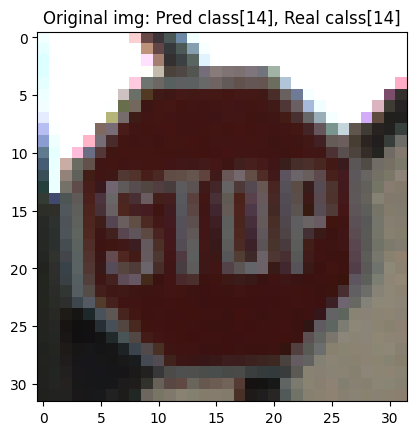

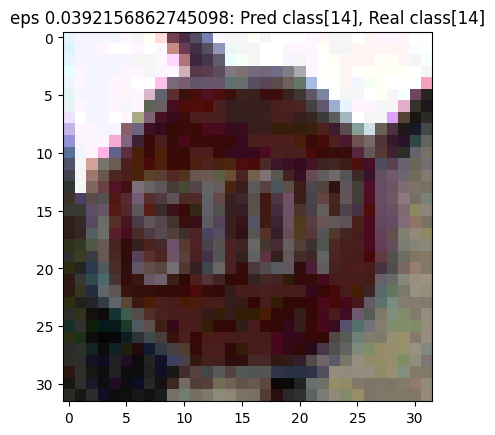

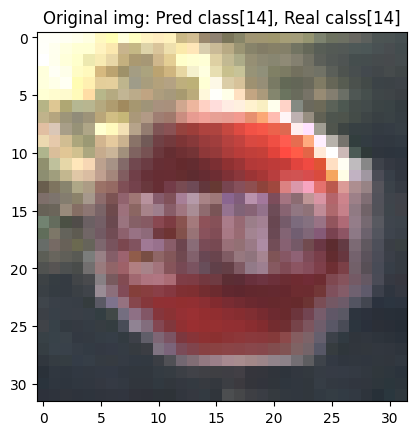

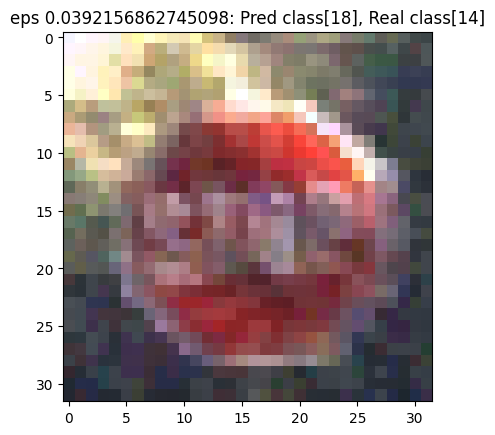

In [ ]:
# Отобразим 5 разных изображений для визуализации действия атаки
range = [0, 10, 20, 30, 40]
i = 0
for index in range:
  plt.figure(i)
  pred = np.argmax(model.predict(x_test[index:index+1]))
  plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[index])}]")
  plt.imshow(x_test[index])
  plt.show()
  i += 1
  pred = np.argmax(model.predict(x_test_adv[index:index+1]))
  plt.figure(i)
  plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[index])}]")
  plt.imshow(x_test_adv[index])
  plt.show()